# Оценка риска ДТП для сервиса каршеринга

### Описание проекта
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

### Цель проекта
Выбрать наилучшую модель для предсказания риска происшествия на маршруте

### Задачи
 - исследовать данные;
 - подготовить данные;
 - создать модель;
 - исследовать основные факторы ДТП;
 - Помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
 -  - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
 -  - Какие ещё факторы нужно учесть?
 -  - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

#### Импортируем библиотеки

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlalchemy
from  sqlalchemy import create_engine 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import  f1_score, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from multiprocessing import Pool
from sklearn.metrics import recall_score, precision_score

pd.set_option('display.max_columns', None)

RANDOM_STATE = 42

In [3]:
# !pip install psycopg2

## Загрузка таблиц sql

In [4]:
db_config = {
'user': '', # имя пользователя,
'pwd': '', # пароль,
'host': '',
'port': , # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

## Первичное исследование таблиц

#### Таблица `сase_ids`

In [6]:
query = '''
SELECT *
FROM case_ids
LIMIT 10
'''
df_ids = pd.read_sql_query(query, con=engine)

df_ids.info()
display(df_ids.head())

#### Таблица `vehicles`

In [7]:
query = '''
SELECT *
FROM vehicles
LIMIT 10
'''
df_vehicles = pd.read_sql_query(query, con=engine)

df_vehicles.info()
display(df_vehicles.head())

| Описание                              | Обозначение в таблице | Подробнее                                                    |
| :------------------------------------ | :-------------------- | :----------------------------------------------------------- |
| Индекс текущей таблицы                | ID                    | Номер в таблице                                              |
| Идентификационный номер в базе данных | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Тип кузова                            | VEHICLE_TYPE          | MINIVAN<br />COUPE<br />SEDAN<br />HATCHBACK<br />OTHER      |
| Тип КПП                               | VEHICLE_TRANSMISSION  | auto (Автоматическая)<br />manual (Ручная)<br />- — Not Stated (Не указано) |
| Возраст автомобиля (в годах)          | VEHICLE_AGE           | число                                                        |

#### Таблица `collisions`

In [8]:
query = '''
SELECT *
FROM collisions
LIMIT 10
'''
df_col = pd.read_sql_query(query, con=engine)

df_col.info()
display(df_col.head())

| Описание                                           | Обозначение в таблице       | Подробнее                                                    |
| :------------------------------------------------- | :-------------------------- | :----------------------------------------------------------- |
| Идентификационный Номер в базе данных              | CASE_ID                     | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Дата происшествия                                  | COLLISION_DATE              | Формат год/месяц/день                                        |
| Время происшествия                                 | COLLISION_TIME              | Формат: 24-часовой                                           |
| Является ли место происшествие перекрёстком        | INTERSECTION                | Y — Intersection (перекрёсток)<br />N — Not Intersection (не перекрёсток)<br />-- — Not stated (Не указано) |
| Погода                                             | WEATHER_1                   | A — Clear (Ясно)<br />B — Cloudy (Облачно)<br />C — Raining (Дождь)<br />D — Snowing (Снегопад)<br />E — Fog (Туман)<br />F — Other (Другое)<br />G — Wind (Ветер)<br />- — Not Stated (Не указано) |
| Серьёзность происшествия                           | COLLISION_DAMAGE            | 1 — FATAL ТС (Не подлежит восстановлению)<br />2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br />3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br />4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br />0 – SCRATCH (Царапина) |
| Основной фактор аварии                             | PRIMARY_COLL_FACTOR         | A — Code Violation (Нарушение правил ПДД)<br />B — Other Improper Driving (Другое неправильное вождение)<br />C — Other Than Driver (Кроме водителя)<br />D — Unknown (Неизвестно)<br />E — Fell Asleep (Заснул)<br />- — Not Stated (Не указано) |
| Состояние дороги                                   | ROAD_SURFACE                | A — Dry (Сухая)<br />B — Wet (Мокрая)<br />C — Snowy or Icy (Заснеженная или обледенелая)<br />D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br />- — Not Stated (Не указано) |
| Освещение                                          | LIGHTING                    | A — Daylight (Дневной свет)<br />B — Dusk-Dawn (Сумерки-Рассвет)<br />C — Dark-Street Lights (Темно-Уличные фонари)<br />D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br />E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br />- — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП    | COUNTY_CITY_LOCATION        | число                                                        |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION             | список разных названий, категориальный тип данных            |
| Направление движения на перекрёстке                | DIRECTION                   | N — North (Север)<br />E — East (Восток)<br />S — South (Юг)<br />W — West (Запад)<br />- or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)               | DISTANCE                    | число                                                        |
| Тип дороги                                         | LOCATION_TYPE               | H — Highway (Шоссе)<br />I — Intersection (Перекрёсток)<br />R — Ramp (or Collector) (Рампа)<br />- or blank — Not State Highway (Не указано) |
| Количество участников                              | PARTY_COUNT                 | число                                                        |
| Категория нарушения                                | PCF_VIOLATION_CATEGORY      | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br />02 — Impeding Traffic (Препятствие движению транспорта)<br />03 — Unsafe Speed (Превышение скорости)<br />04 — Following Too Closely (Опасное сближение)<br />05 — Wrong Side of Road (Неправильная сторона дороги)<br />06 — Improper Passing (Неправильное движение)<br />07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br />08 — Improper Turning (Неправильный поворот)<br />09 — Automobile Right of Way (Автомобильное право проезда)<br />10 — Pedestrian Right of Way (Пешеходное право проезда)<br />11 — Pedestrian Violation (Нарушение пешеходами)<br />12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br />13 — Hazardous Parking (Неправильная парковка)<br />14 — Lights (Освещение)<br />15 — Brakes (Тормоза)<br />16 — Other Equipment (Другое оборудование)<br />17 — Other Hazardous Violation (Другие нарушения)<br />18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br />19 — Speeding (Скорость)<br />20 — Pedestrian dui (Нарушение пешехода)<br />21 — Unsafe Starting or Backing (Опасный старт)<br />22 — Other Improper Driving (Другое неправильное вождение)<br />23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br />24 — Fell Asleep (Заснул)<br />00 — Unknown (Неизвестно)<br />- — Not Stated (Не указано) |
| Тип аварии                                         | TYPE_OF_COLLISION           | A — Head-On (Лоб в лоб)<br />B — Sideswipe (Сторона)<br />C — Rear End (Столкновение задней частью)<br />D — Broadside (Боковой удар)<br />E — Hit Object (Удар объекта)<br />F — Overturned (Опрокинутый)<br />G — Vehicle (транспортное средство/ Пешеход)<br />H — Other (Другое)<br />- — Not Stated (Не указано) |
| Дополнительные участники ДТП                       | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль)<br />Fixed object (Неподвижный объект)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Pedestrian (Пешеход)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Bicycle (Велосипедист)<br />Non-collision (Не столкновение)<br />Other object (Другой объект)<br />Motor vehicle on other roadway (Автомобиль на другой проезжей)<br />Animal (Животное)<br />Train (Поезд) |
| Дорожное состояние                                 | ROAD_CONDITION_1            | A — Holes, Deep Ruts (Ямы, глубокая колея)<br />B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br />C — Obstruction on Roadway (Препятствие на проезжей части)<br />D — Construction or Repair Zone (Зона строительства или ремонта)<br />E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br />F — Flooded (Затоплено)<br />G — Other (Другое)<br />H — No Unusual Condition (Нет ничего необычного)<br />- — Not Stated (Не указано) |
| Устройство управления                              | control_device              | A — Functioning (Функционирует)<br />B — Not Functioning (Не функционирует)<br />C — Obscured (Затемнённый)<br />D — None (Нет)<br />- — Not Stated (Не указано) |

#### Таблица `parties`

In [9]:
query = '''
SELECT *
FROM parties
LIMIT 10
'''
df_par = pd.read_sql_query(query, con=engine)

df_par.info()
display(df_par.head())

| Описание                                                     | Обозначение в таблице | Подробнее                                                    |
|:------------------------------------------------------------ |:--------------------- |:------------------------------------------------------------ |
| Идентификационный номер                                      | ID                    | Уникальный идентификатор                                                                          |
| Идентификационный номер в базе данных                        | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Номер участника происшествия                                 | PARTY_NUMBER          | От 1 до N — по числу участников происшествия                 |
| Тип участника происшествия                                   | PARTY_TYPE            | 1 — Car (Авто)<br />2 — Road bumper (Дорожные знаки)<br />3 — Building (Строения)<br />4 — Road signs (Отбойник)<br />5 — Other (Другое)<br />6 — Operator (Оператор)<br />- — Not Stated (Не указано) |
| Виновность участника                                         | AT_FAULT              | 0/1                                                          |
| Сумма страховки (тыс. $)                                     | INSURANCE_PREMIUM     | число                                                        |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL   | E — Under Drug Influence (Под воздействием лекарств)<br />F — Impairment — Physical (Ухудшение состояния)<br />G — Impairment Unknown (Не известно)<br />H — Not Applicable (Не оценивался)<br />I — Sleepy/Fatigued (Сонный/Усталый)- — Not Stated (Не указано) |
| Трезвость участника                                          | PARTY_SOBRIETY        | A — Had Not Been Drinking (Не пил)<br />B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br />C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br />D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br />G — Impairment Unknown (Неизвестно ухудшение)<br />H — Not Applicable (Не оценивался)<br />- — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE      | 0/1                                                          |

- Все таблицы имеют набор данных;
- Количество таблиц соответствует условию задачи;
- Общий ключ для связи таблиц `case_id`.

##  Проведите статистический анализ факторов ДТП

#### Распределение количества аварий по годам:

In [10]:
query = '''
SELECT  EXTRACT(year from collision_date) as years,
COUNT(case_id) as total_collisions
FROM collisions
GROUP BY years
ORDER BY total_collisions DESC
'''
df_years = pd.read_sql_query(query, con=engine)
display(df_years)

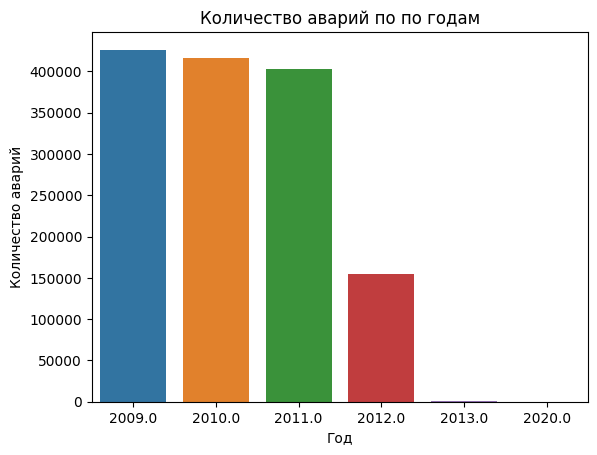

In [11]:
sns.barplot(x = df_years['years'], y = df_years['total_collisions'])
plt.title('Количество аварий по по годам')
plt.xlabel('Год')
plt.ylabel('Количество аварий');

Видим, что полные данные есть только за 2009-2011 год, в 2012 их вполовину меньше, а далее полных данных нет, только отдельные случаи

#### Распределение количества аварий по месяцам

In [12]:
query = '''
SELECT  EXTRACT(month from collision_date) as month,
COUNT(case_id) as total_collisions
FROM collisions
WHERE EXTRACT(year from collision_date) IN (2009, 2010, 2011)
GROUP BY month
ORDER BY total_collisions DESC
'''

df_month = pd.read_sql_query(query, con=engine)
display(df_month)

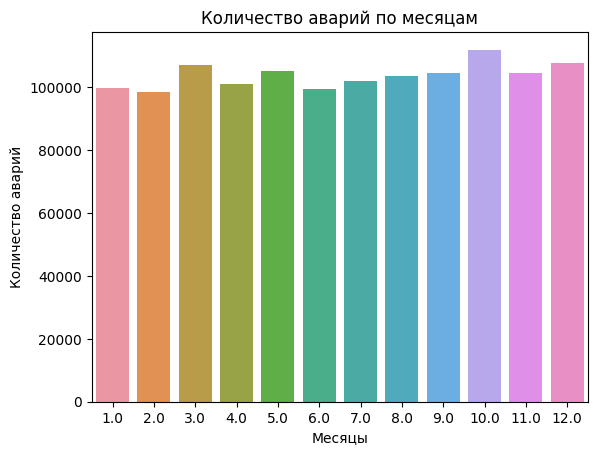

In [13]:
sns.barplot(x = df_month['month'], y = df_month['total_collisions'])
plt.title('Количество аварий по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий');


В среднем количество ДТП каждый месяц примерно одинаковое, но при этом больше всего ДТП происходит в октябре, а меньше в феврале

#### Распределение количества ДТП в зависимости от состояния дороги

In [14]:
query = '''
SELECT DISTINCT road_condition_1,
       COUNT(collision_damage) OVER (partition by road_condition_1) AS count_road_condition       
FROM collisions
WHERE road_condition_1 != 'normal'
ORDER BY count_road_condition DESC
'''
road_condition = pd.read_sql_query(query, con=engine)
display(road_condition)

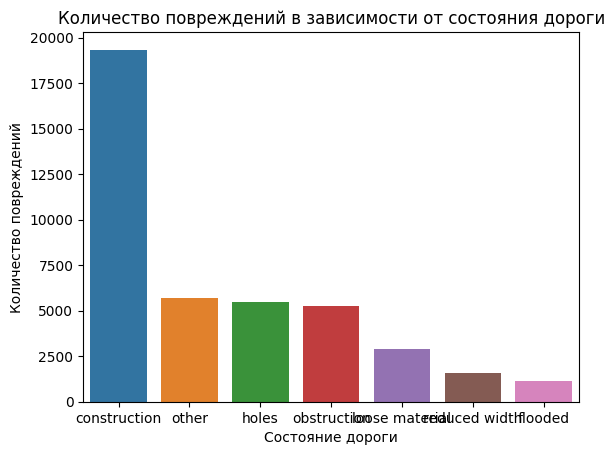

In [15]:
sns.barplot(data = road_condition, x='road_condition_1', y='count_road_condition')
plt.title('Количество повреждений в зависимости от состояния дороги')
plt.xlabel('Состояние дороги')
plt.ylabel('Количество повреждений');

Из-за значительно большего количества дорог без повреждений, ДТП случаются на них

#### Cамые частые причины ДТП:


In [16]:
query = '''
SELECT DISTINCT primary_collision_factor,
       COUNT(primary_collision_factor) AS count_collision_factor
FROM collisions
WHERE primary_collision_factor != 'unknown' 
GROUP BY primary_collision_factor
ORDER BY count_collision_factor DESC
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

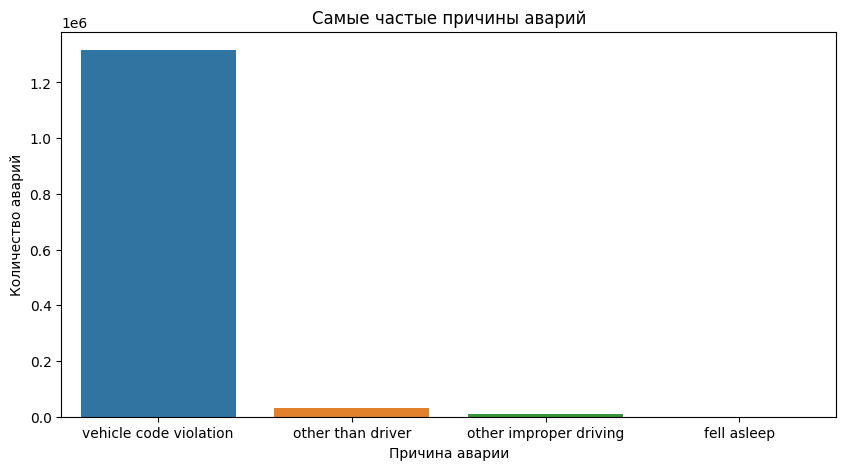

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(data = collisions_reasons, x = 'primary_collision_factor', y = 'count_collision_factor')
plt.title('Самые частые причины аварий')
plt.xlabel('Причина аварии')
plt.ylabel('Количество аварий');

Cамой частой причиной аварий является нарушение ПДД

#### Самые опасные виды нарушений ПДД

In [18]:
query = '''
SELECT DISTINCT pcf_violation_category,
       COUNT(pcf_violation_category) AS count_pcf_violation_category
FROM collisions
GROUP BY pcf_violation_category
ORDER BY count_pcf_violation_category DESC
limit 5
'''
violation_category = pd.read_sql_query(query, con=engine)
violation_category 

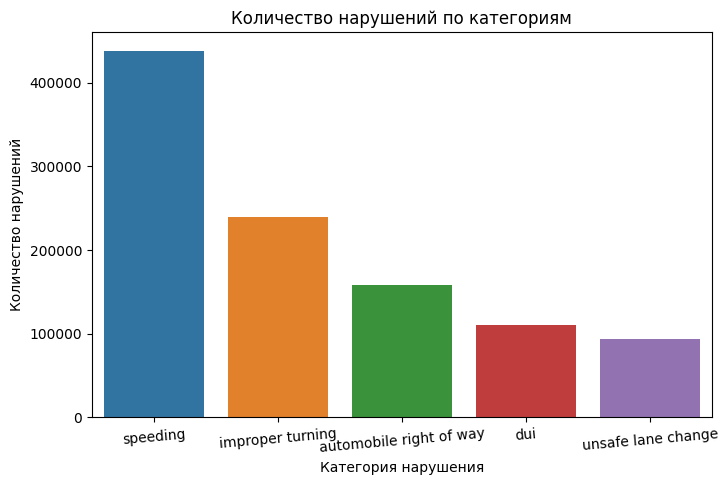

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(data = violation_category, x='pcf_violation_category', y='count_pcf_violation_category')
plt.title('Количество нарушений по категориям')
plt.xticks(rotation=5)
plt.xlabel('Категория нарушения')
plt.ylabel('Количество нарушений');

Самые частые нарушения - превышение скорости, а также неправильные повороты

#### Распределение ДТП от степени освещенности дороги

In [20]:
query = '''
SELECT DISTINCT lighting,
       COUNT(case_id) AS count_collisions
FROM collisions
GROUP BY lighting
ORDER BY count_collisions desc
'''
lighting_damage = pd.read_sql_query(query, con=engine)
lighting_damage

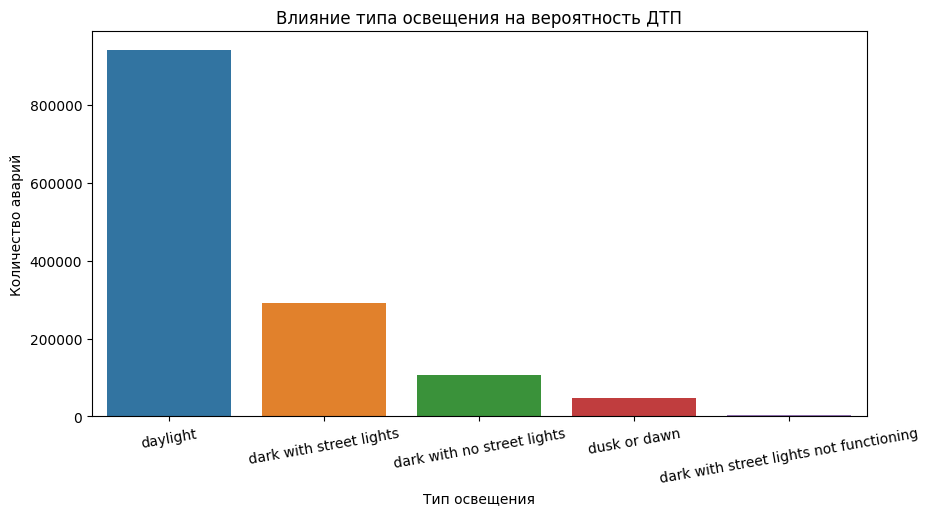

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(data = lighting_damage, x='lighting', y='count_collisions')
plt.title('Влияние типа освещения на вероятность ДТП')
plt.xticks(rotation=10)
plt.xlabel('Тип освещения')
plt.ylabel('Количество аварий');

Больше всего ДТП происходит днем, можно предположить, что днем наибольший поток автомобилей

In [27]:
query = '''
SELECT c.weather_1 AS weather_condition, p.party_sobriety AS driver_sobriety, COUNT(*) AS count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
GROUP BY c.weather_1, p.party_sobriety;
'''
sobriety_weather = pd.read_sql_query(query, con=engine)
sobriety_weather.head()



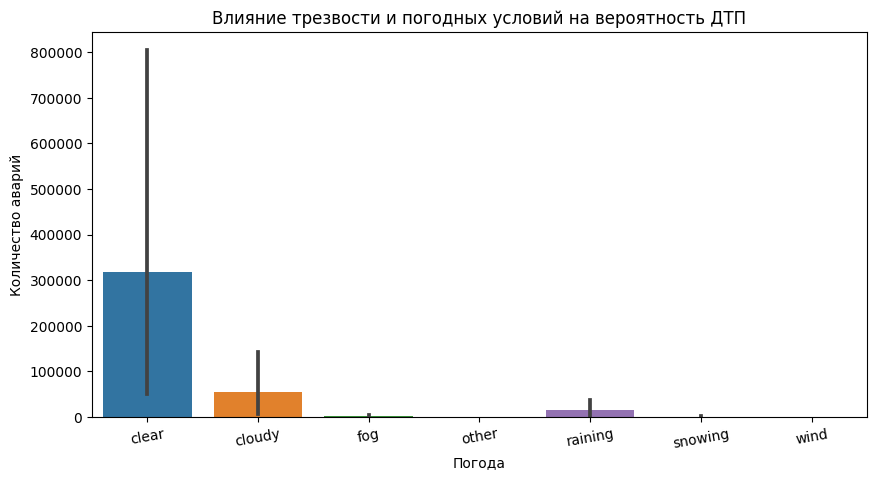

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(data = sobriety_weather, x='weather_condition', y='count')
plt.title('Влияние трезвости и погодных условий на вероятность ДТП')
plt.xticks(rotation=10)
plt.xlabel('Погода')
plt.ylabel('Количество аварий');

In [30]:
query = '''
SELECT v.vehicle_transmission, COUNT(*) AS count
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
GROUP BY v.vehicle_transmission;
'''
transmission_col = pd.read_sql_query(query, con=engine)
transmission_col.head()

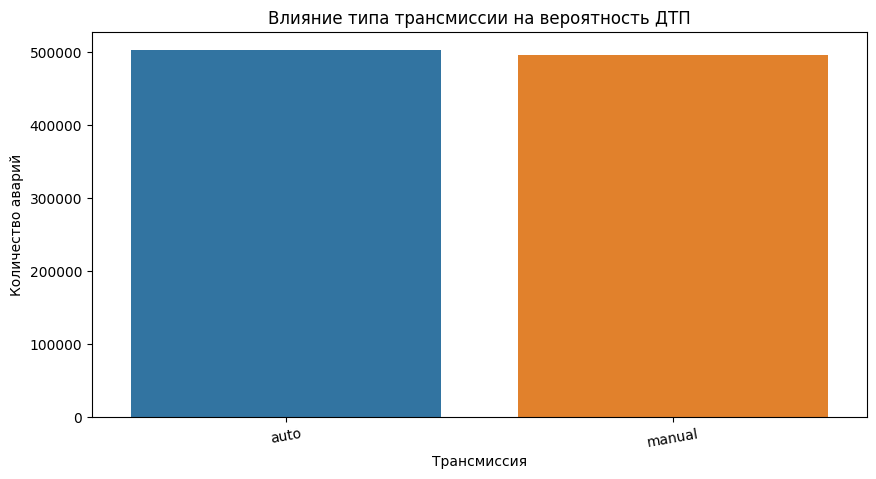

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(data = transmission_col, x='vehicle_transmission', y='count')
plt.title('Влияние типа трансмиссии на вероятность ДТП')
plt.xticks(rotation=10)
plt.xlabel('Трансмиссия')
plt.ylabel('Количество аварий');

- наибольшее количество аварий приходится на март.
- ДТП чаще всего случаются на дорогах без повреждений.
- самой частой причиной аварий является нарушение ПДД.
- самыми частыми нарушениями является превышение скорости.
- чаще всего аварии происходят при дневном освещении.
- дтп с пьяными водителями чаще всего происходят в чистую погоду.
- дтп происходят с машинами любого типа трансмиссии, механического или автоматического.

## Создайте модель для оценки водительского риска

**Подготовьте набор данных на основе первичного предположения заказчика**:
- Выберите тип виновника — только машина (car). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

In [34]:
query = '''

WITH collisions AS (SELECT *,
                           EXTRACT(MONTH FROM collision_date) AS collision_month
                    FROM collisions
                    WHERE case_id IN (SELECT DISTINCT case_id
                                      FROM parties
                                      WHERE at_fault = 1 AND party_type = 'car'
                                      )
                                      AND EXTRACT(YEAR FROM collision_date) = 2012
                                      AND collision_damage NOT LIKE 'scratch'
                    )
                    
SELECT p.at_fault,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use,
       c.weather_1,
       c.road_surface,
       c.lighting,
       c.road_condition_1,
       c.intersection,
       c.control_device,
       v.vehicle_age

FROM parties AS p
JOIN collisions AS c ON p.case_id = c.case_id
JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.county_city_location IS NOT NULL 
''' 
df = pd.read_sql_query(query, con = engine)
display(df.sample(5))

Факторы, которые могут влиять на вероятность ДТП:

**Таблица parties:**
- 'party_sobriety' - Уровень трезвости виновника (точно может влиять) 
- 'party_drug_physical' - Состояние участника: физическое или с учётом принятых лекарств.
- 'cellphone_in_use' - Возможность говорить по громкой связи в машине или нет.

**Таблица collisions:**
- 'weather_1' - Погода. 
- 'road_surface' - Состояние дороги.
- 'lighting' - Освещение.
- 'road_condition_1' - Дорожное состояние.
- 'intersections' - Является ли перекрестком.
- control_device - Устройство управления.

**Таблица vehicles:**
- vehicle_age

#### Предобработка данных

In [35]:
df.info()

Найдем пропуски

In [36]:
df.isnull().mean()

Столбец `party_drug_physical` бесполезен, т.к. в нем более 94% пропусков

In [37]:
df = df.drop('party_drug_physical', axis = 1 )

Удалим пропуски в других столбцах, суммарно их меньше 10% датасета

In [38]:
df = df.dropna()
df.info()

In [39]:
df.intersection.value_counts()

In [40]:
# Выделим колонки с категориальными и числовыми данными.
categorical = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'road_condition_1', 'control_device']
numeric = ['vehicle_age']

In [41]:
X = df.drop(['at_fault'], axis=1)
y = df['at_fault']

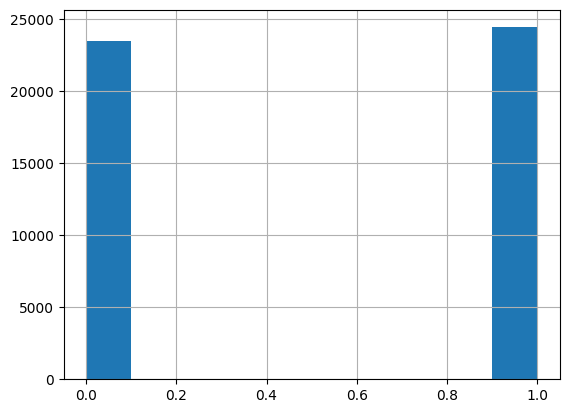

In [42]:
y.hist();

In [43]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [44]:
# масштабирование числовых данных
numeric_preproces = Pipeline([('scaler',StandardScaler())])

In [45]:
# кодирование категориальных данных 
categorial_preproces = Pipeline([('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

In [46]:
# подготовка данных для Случайного леса
preprocessor = ColumnTransformer([
    (
        'categorical', 
        categorial_preproces, 
        categorical
    ),
    (
        'numerical', 
        numeric_preproces, 
        numeric
    )
])

In [47]:
pipe_for_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [48]:
pipe_for_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=RANDOM_STATE))
])

### RF classifier

In [49]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}

In [50]:
%%time
grid_tree =  GridSearchCV(pipe_for_tree, param, cv = 5, scoring= 'f1')
grid_tree.fit(X_train,y_train)
predict_train_rf = grid_tree.predict(X_train)
scores_1 = grid_tree.best_score_
print(f'scores_1:{scores_1}')

### LGBM classifier

In [51]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}

In [52]:
%%time
grid_lgbm = GridSearchCV(pipe_for_lgbm, param, cv = 5, scoring= 'f1', verbose=False)
grid_lgbm.fit(X_train, y_train)
predict_train_lgbm = grid_lgbm.predict(X_train)
scores_2 = grid_lgbm.best_score_
print(f'scores_2:{scores_2}')

### CatBoost classifier

In [53]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [54]:
%%time
cat_features = categorical
model = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_features, eval_metric = 'F1')

grid = {'depth': [5, 10],
        'l2_leaf_reg': [1, 3, 5]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv = 5, 
                                       plot=True)

In [64]:
best_params = grid_search_result['params']
print("Лучшие параметры модели CatBoost:")
print(best_params)

In [55]:
model.best_score_

In [56]:
scores_3 = model.best_score_['learn']['F1']

print(f'scores_3:{scores_3}')

In [57]:
models = pd.DataFrame(data=[('Random_Forest', scores_1), 
                                             ('LGBM', scores_2),
                                            ('CatBoost', scores_3)], 
                                       columns=['model', 'f1_score', ])
display(models)

Используя лучшую модель возьмем тестовую выборку

Были расмотрены три вида моделей, в качестве метрики выбрана F1, как метрика соединяющая precision и recall.

In [58]:
predict_test_cat = model.predict(X_test)
test_scores = f1_score(y_test, predict_test_cat)
print(f'test_scores:{test_scores}')

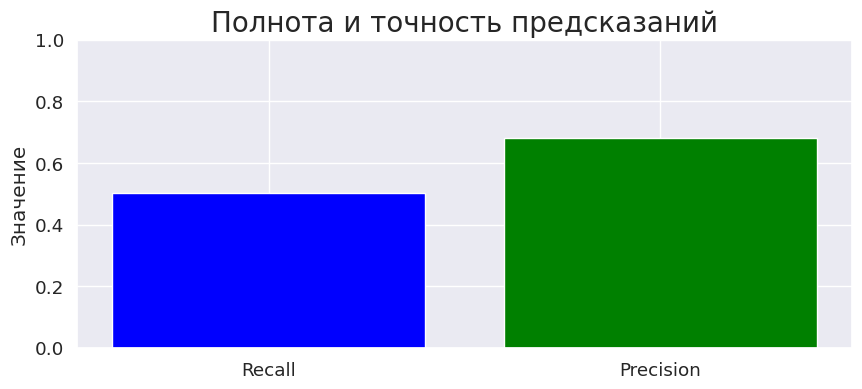

In [59]:
recall = recall_score(y_test, predict_test_cat)
precision = precision_score(y_test, predict_test_cat)

print(f'Полнота: {recall}')
print(f'Точность: {precision}')

sns.set(font_scale=1.2)
plt.figure(figsize=(10, 4))
metrics = ['Recall', 'Precision']
values = [recall, precision]
plt.bar(metrics, values, color=['blue', 'green'])
plt.title("Полнота и точность предсказаний", size=20)
plt.ylabel('Значение')
plt.ylim([0, 1])

plt.show()

Матрицы ошибок

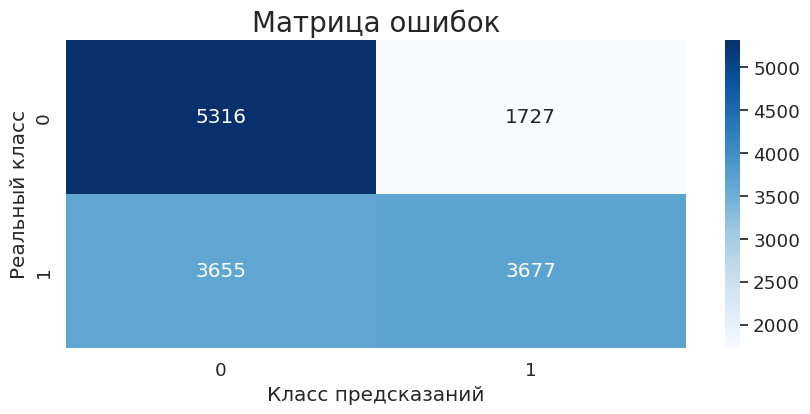

In [60]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(confusion_matrix(y_test, predict_test_cat), 
            annot=True, fmt='g', cmap="Blues")
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

Исходя из матрицы ошибок, можем сделать вывод, что модель в большинстве случае дает TrueNegative результат, но при этом у модели много FalsePositive ошибок

Исходя из этих результатов, мы можем дать оценку работы модели на основе полноты и точности. Полнота (recall) измеряет способность модели обнаруживать положительные случаи, то есть вероятность того, что модель правильно предскажет ДТП. В данном случае, полнота равна 0.5015, что означает, что модель способна предсказать около 50% случаев ДТП.

Точность (precision) измеряет способность модели предсказывать верные положительные случаи, то есть вероятность того, что предсказанное ДТП действительно произошло. В данном случае, точность равна 0.6804, что означает, что около 68% предсказаний модели о ДТП действительно являются верными.

## Проведите анализ важности факторов ДТП

### Feature Importances

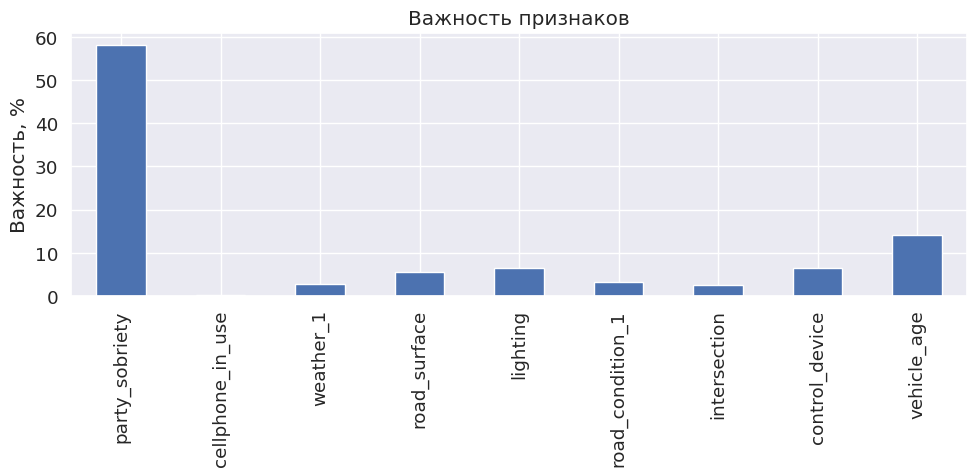

In [61]:
cat_imp = pd.Series(model.get_feature_importance(), X_train.columns)
fig, ax = plt.subplots(figsize=(10,5))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Модель смотрит прежде всего на трезвость водителя

Зависимость ДТП от уровня трезвости

In [62]:
query = '''
SELECT party_sobriety,
       COUNT(case_id) AS count_party_sobriety
FROM parties
WHERE party_sobriety != 'had not been drinking'
   and party_sobriety != 'not applicable'
GROUP BY party_sobriety
ORDER BY count_party_sobriety DESC
'''
party_sobriety = pd.read_sql_query(query, con=engine)
party_sobriety

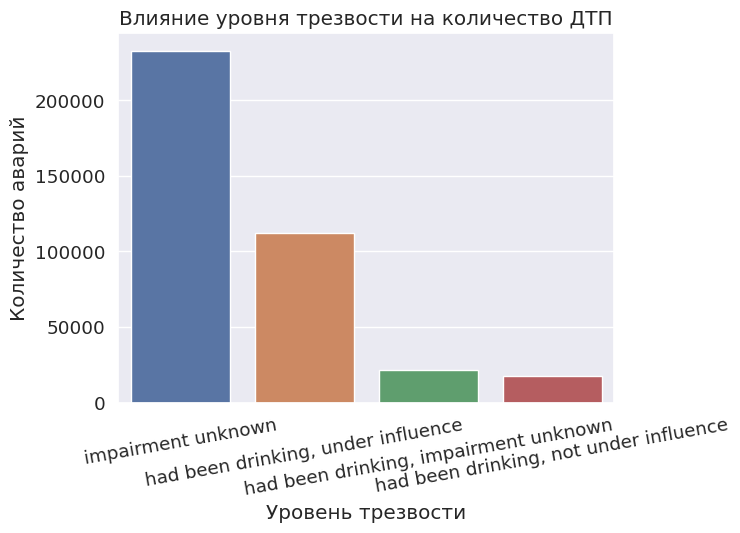

In [63]:
sns.barplot(data = party_sobriety, x='party_sobriety', y='count_party_sobriety')
plt.title('Влияние уровня трезвости на количество ДТП')
plt.xticks(rotation=10)
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество аварий');

Наибольшее количество аварий из-за `impairment unknown (неизвестное ухудшение)`

## Выводы

В ходе проекта были проверены три модели - RandomForest, LGBM и Catboost
Лучший результат: Catboost с использованием grid search выдал лучшие показатели метрики на параметрах 
`'depth': 5, 'l2_leaf_reg': 1`

Результат F1 у лучшей модели (Сatboost) - 0.5774

Так как самый важный фактор ДТП — уровень трезвости виновника (party_sobriety), то можно предложить следующие меры:
оборудовать автомобиль алкозамком, но при этом возникает проблема доверия водителей и есть вероятность оттока пользователей в каршеринги, в которых таких систем нет.